In [4]:
# IPython extension to reload modules before executing user code.
# useful to see immediate results in notebook when modifying imported scripts
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import pandas as pd

import sys
import os

# Add the ../py directory to sys.path
# This allows importing modules from the py directory as if they were in the current directory
module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'py'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Verify it works
print(f"Added to path: {module_path}")

Added to path: /Users/eyal/projects/elzurdo/precision-goal/py


In [59]:
from utils_experiments_continuous import (
    ContinuousSimulation,
    ContinuousHypothesis,
    run_simulations_and_analysis_report
    # BinaryAccounting,
    # BinomialSimulation,
    # BinomialHypothesis,
    # stop_decision_multiple_experiments_multiple_methods,
    # stats_dict_to_df,
    # iteration_counts_to_df,
    # sample_all_iterations_results,
    # report_success_rates_multiple_algos,
    # run_simulations_and_analysis_report, # was called full_analysis

)

from utils_stats import continuous_hdi_ci_limits

from scipy.stats import t as student_t 

In [7]:
import matplotlib.pyplot as plt
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

FIG_WIDTH, FIG_HEIGHT = 8, 6

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = FIG_WIDTH, FIG_HEIGHT
# plt.rcParams["hatch.linewidth"] = 0.2

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Hypothesis

In [38]:
null_mean = 0.
dmean = 0.1 #0.15 # 0.05 - too narrow. This means 5% from the std
rope_precision_fraction = 0.8

In [39]:
hypothesis_mean0 = ContinuousHypothesis(mean_null=null_mean, dmean=dmean, rope_precision_fraction=rope_precision_fraction)


0.0: null hypothesis mean
-0.1: ROPE min
0.1: ROPE max
--------------------
0.16: Precision Goal


In [50]:
N_EXPERIMENTS = 200 #2000
N_SAMPLES = 1000 #1500 # 1500  # in paper called M

## $\mu_{\rm true}=0$

In [61]:
distribution_name = "normal"
mean_true = 0
variance_true = 1

In [ ]:
# Normal distribution: mean=100, variance=25 (std=5)
sim_mean0var1 = ContinuousSimulation(
    distribution=distribution_name, 
    mean=mean_true, 
    variance=variance_true,
    n_experiments=N_EXPERIMENTS,
    n_samples=N_SAMPLES
)


Generating synthetic continuous data with parameter values:
normal: distribution type
0.000: target mean
1.000: target variance
200: experiments
1000: sample size per experiment


In [52]:
%%time
hypothesis_mean0.run_hypothesis_on_experiments(sim_mean0var1.experiments)

/Users/eyal/.pyenv/versions/scrappy-3.8.11/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/eyal/.pyenv/versions/scrappy-3.8.11/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,mean_estimate_mean,mean_estimate_std
hdi_rope,0.855,0.065,0.920,0.080,564.48,233.777972,0.008617,0.115066
pitg,0.425,0.000,0.425,0.575,600.24,32.358115,0.000509,0.041159
epitg,0.880,0.000,0.880,0.120,707.33,144.904200,0.000058,0.028827


CPU times: user 11min 17s, sys: 5.89 s, total: 11min 23s
Wall time: 11min 33s


In [53]:
hypothesis_mean0.method_df_stats["hdi_rope"].head(4)

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,sample_mean,sample_std,n,hdi_min,hdi_max,precision_goal_achieved,reject,precision,se,coefficient_of_variation,relative_precision
experiment_number,,,,,,,,,,,,,,,,,
0,458.0,True,False,False,True,False,0.009886,0.968333,458,-0.079033,0.098804,False,False,0.177837,0.045247,97.953663,17.989444
1,30.0,False,False,True,True,False,0.421874,0.860767,30,0.100458,0.743289,False,True,0.642831,0.157154,2.040344,1.523754
2,472.0,True,False,False,True,False,-0.012481,0.959012,472,-0.099221,0.074259,False,False,0.173480,0.044142,76.836103,13.899201
3,436.0,True,False,False,True,False,-0.001661,1.038810,436,-0.099441,0.096119,False,False,0.195560,0.049750,625.316001,117.718416


In [54]:
experiment_idxs = list(sorted(set(hypothesis_mean0.method_df_stats["pitg"].query("inconclusive").index) &\
set(hypothesis_mean0.method_df_stats["epitg"].query("accept").index) &\
set(hypothesis_mean0.method_df_stats["hdi_rope"].query("sample_mean > 0.1").index)))
len(experiment_idxs)

4

[ 1.36913281e+00 -4.54997560e-01  1.17383700e+00 -1.17681897e+00
 -1.10450896e+00  1.09679472e+00  1.74589064e+00  5.83867511e-01
 -1.41128702e+00  1.13754551e+00 -9.33941610e-01 -1.10262189e+00
  1.54548142e-01 -4.96705141e-01  8.12566720e-01  5.14197115e-01
 -3.40127017e-01  6.36558949e-01  2.23075922e+00 -2.76779954e-01
  3.50921183e-01  6.12365366e-01  5.71124399e-01  2.09808837e+00
  1.15805468e+00 -9.79133784e-01 -9.50674137e-01 -1.14810738e-01
  5.86300199e-01  1.02769657e+00  1.02229743e+00 -1.60457101e-02
  6.02505884e-01  1.59255734e+00  5.34871163e-01  3.87361823e-01
  9.85846050e-01  2.35499263e-01  7.05412266e-01  1.88188171e+00
 -1.14865747e+00 -1.68630019e-01 -5.86683129e-01 -6.56896618e-01
 -5.49460297e-01 -2.11743733e+00 -4.26309567e-01  1.08399991e+00
 -1.22850910e+00 -1.71721076e+00 -5.68695365e-01 -7.67402274e-01
  8.50274709e-01  1.74863279e+00  2.22746958e+00 -7.35144462e-01
  6.03568770e-01 -2.14915521e-02  4.19453170e-01  5.73695677e-01
 -6.33474366e-02 -9.42852

,decision_iteration,accept,reject_below,reject_above,conclusive,inconclusive,sample_mean,sample_std,n,hdi_min,hdi_max,goal_achieved,reject,precision,se,coefficient_of_variation,relative_precision
experiment_number,,,,,,,,,,,,,,,,,
2,2.0,False,False,False,False,True,0.457068,1.289855,2,-11.131819,12.045955,False,False,23.177774,0.912065,2.822022,50.709726
3,3.0,False,False,False,False,True,0.695991,1.001557,3,-1.792014,3.183995,False,False,4.976009,0.578249,1.439037,7.149533
4,4.0,False,False,False,False,True,0.227788,1.243221,4,-1.750453,2.206030,False,False,3.956483,0.621610,5.457790,17.369123
5,5.0,False,False,False,False,True,-0.038671,1.230529,5,-1.566575,1.489232,False,False,3.055807,0.550309,31.820348,79.020362
6,6.0,False,False,False,False,True,0.150573,1.194254,6,-1.102719,1.403865,False,False,2.506585,0.487552,7.931384,16.646954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996.0,True,False,False,True,False,-0.027644,0.986997,996,-0.089014,0.033727,True,False,0.122742,0.031274,35.704464,4.440169
997,997.0,True,False,False,True,False,-0.027608,0.986502,997,-0.088917,0.033702,True,False,0.122619,0.031243,35.732921,4.441474
998,998.0,True,False,False,True,False,-0.029213,0.987310,998,-0.090541,0.032116,True,False,0.122657,0.031253,33.797473,4.198794


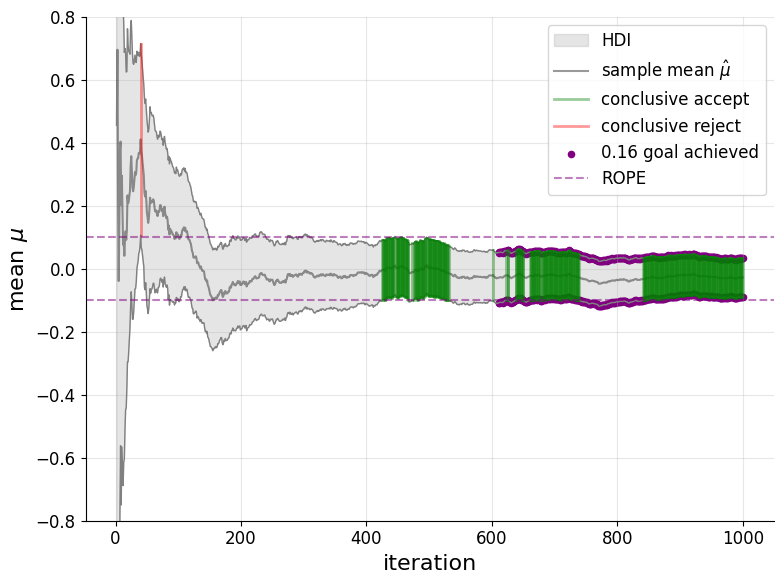

In [58]:
iexperiment = experiment_idxs[3]

method_names = ["hdi_rope", "pitg", "epitg"]

method_names = ["pitg"]

hypothesis_mean0.one_experiment_all_iterations(iexperiment, viz=True, true_mean=None, 
                                      xlim=None, method_names=None, ylim=(-0.8,0.8))

In [ ]:
distribution_name = "normal"
mean_true = 0
variance_true = 1

dmean = 0.1 #0.15 # 0.05 - too narrow. This means 5% from the std
rope_precision_fraction = 0.8

In [62]:
from utils_experiments_shared import (
    #stats_dict_to_df, 
    #iteration_counts_to_df,
    report_success_rates_multiple_algos,
)

In [65]:
# Summary Stats
df_stats_0pt0 = report_success_rates_multiple_algos(hypothesis_mean0.method_df_stats.copy(), data_type='continuous')

count  param_frac  param_mean  param_std  param_p25  \
algorithm group                                                               
pitg      overall         200       1.000    0.000509   0.041159  -0.024968   
          conclusive       85       0.425   -0.001099   0.012532  -0.011493   
          inconclusive    115       0.575    0.001697   0.053274  -0.043855   
          accept           85       0.425   -0.001099   0.012532  -0.011493   
epitg     overall         200       1.000    0.000058   0.028827  -0.021233   
          conclusive      176       0.880    0.000919   0.021160  -0.018776   
          inconclusive     24       0.120   -0.006258   0.061120  -0.051914   
          accept          176       0.880    0.000919   0.021160  -0.018776   
hdi_rope  overall         200       1.000    0.008617   0.115066  -0.011423   
          conclusive      184       0.920    0.010580   0.118545  -0.008316   
          inconclusive     16       0.080   -0.013962   0.060133  -0.056831   
          accept          171       0.855    0.002885   0.017920  -0.007475   
          reject           13       0.065    0.111803   0.444763  -0.401415   

                        param_median  param_p75  stop_iter_mean  \
algorithm group                                                   
pitg      overall          -0.001910   0.029774      600.240000   
          conclusive       -0.003042   0.010257      597.188235   
          inconclusive      0.022099   0.046752      602.495652   
          accept           -0.003042   0.010257      597.188235   
epitg     overall          -0.001910   0.020487      707.330000   
          conclusive       -0.000272   0.019997      667.420455   
          inconclusive     -0.045015   0.062151     1000.000000   
          accept           -0.000272   0.019997      667.420455   
hdi_rope  overall           0.001758   0.018016      564.480000   
          conclusive        0.001890   0.016870      526.608696   
          inconclusive     -0.049439   0.047021     1000.000000   
          accept            0.001781   0.015893      563.690058   
          reject            0.378351   0.421874       38.846154   

                        stop_iter_std  stop_iter_p25  stop_iter_median  \
algorithm group                                                          
pitg      overall           32.358115         580.75             600.5   
          conclusive        32.425186         578.00             599.0   
          inconclusive      32.263818         585.50             602.0   
          accept            32.425186         578.00             599.0   
epitg     overall          144.904200         599.00             644.0   
          conclusive       102.605566         596.75             628.5   
          inconclusive       0.000000        1000.00            1000.0   
          accept           102.605566         596.75             628.5   
hdi_rope  overall          233.777972         427.75             517.5   
          conclusive       203.481096         419.75             496.5   
          inconclusive       0.000000        1000.00            1000.0   
          accept           158.064331         436.00             516.0   
          reject            11.929279          30.00              36.0   

                        stop_iter_p75  conclusive_mean  accept_mean  \
algorithm group                                                       
pitg      overall              624.25            0.425     0.425000   
          conclusive           616.00            1.000     1.000000   
          inconclusive         625.50            0.000     0.000000   
          accept               616.00            1.000     1.000000   
epitg     overall              801.75            0.880     0.880000   
          conclusive           728.75            1.000     1.000000   
          inconclusive        1000.00            0.000     0.000000   
          accept               728.75            1.000     1.000000   
hdi_rope  o

In [77]:
hypothesis_mean0.decision_correctness(mean_true)
hypothesis_mean0.df_experiment_correctness.head(4)

,hdi_rope_decision_iteration,hdi_rope_accept,hdi_rope_reject_below,hdi_rope_reject_above,hdi_rope_inconclusive,hdi_rope_param_value,hdi_rope_decision_correct,pitg_decision_iteration,pitg_accept,pitg_reject_below,...,pitg_inconclusive,pitg_param_value,pitg_decision_correct,epitg_decision_iteration,epitg_accept,epitg_reject_below,epitg_reject_above,epitg_inconclusive,epitg_param_value,epitg_decision_correct
experiment_idx,,,,,,,,,,,,,,,,,,,,,
0,458,True,False,False,False,0.009886,True,574,True,False,...,False,-0.015578,True,574,True,False,False,False,-0.015578,True
1,30,False,False,True,False,0.421874,False,627,False,False,...,True,0.076747,True,1000,False,False,False,True,0.070836,True
2,472,True,False,False,False,-0.012481,True,583,True,False,...,False,-0.000938,True,583,True,False,False,False,-0.000938,True
3,436,True,False,False,False,-0.001661,True,651,True,False,...,False,-0.005718,True,651,True,False,False,False,-0.005718,True


In [71]:
sims_hypo0pt0_results = {
    0.0: {
        "synth": sim_mean0var1,
        "hypothesis": hypothesis_mean0,
        "df_stats": df_stats_0pt0.copy()
    }
}

sims_hypo0pt0_results.keys()

dict_keys([0.0])

# $\mu_{\rm true}=0.2$

In [73]:
%%time

mean_true_not_null = 0.2



sims_hypo0pt0_results[mean_true_not_null]  = run_simulations_and_analysis_report(mean_true=mean_true_not_null,
                                        mean_null=null_mean,
                                        dmean=dmean,
                                        distribution=distribution_name,
                                        variance=variance_true,
                                        n_samples=N_SAMPLES,
                                        n_experiments=N_EXPERIMENTS,
                                        seed=42,
                                        rope_precision_fraction=rope_precision_fraction,
                                        viz= True)

Generating synthetic continuous data with parameter values:
normal: distribution type
0.200: target mean
1.000: target variance
200: experiments
1000: sample size per experiment
0.0: null hypothesis mean
-0.1: ROPE min
0.1: ROPE max
--------------------
0.16: Precision Goal


/Users/eyal/.pyenv/versions/scrappy-3.8.11/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/eyal/.pyenv/versions/scrappy-3.8.11/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,accept,reject,conclusive,inconclusive,stop_iter_mean,stop_iter_std,mean_estimate_mean,mean_estimate_std
hdi_rope,0.0,0.94,0.94,0.06,273.28,278.304922,0.296609,0.128957
pitg,0.0,0.73,0.73,0.27,600.24,32.358115,0.200509,0.041159
epitg,0.0,0.93,0.93,0.07,655.73,121.303337,0.204865,0.035085


TODO: Implement decision_correctness for continuous (true_mean=0.2)
TODO: Implement plot_decision_rates for continuous data
TODO: Implement plot_stop_iter_sample_rates for continuous data


count  param_frac  param_mean  param_std  param_p25  \
algorithm group                                                               
pitg      overall         200        1.00    0.200509   0.041159   0.175032   
          conclusive      146        0.73    0.219326   0.028870   0.194380   
          inconclusive     54        0.27    0.149634   0.021635   0.137279   
          reject          146        0.73    0.219326   0.028870   0.194380   
epitg     overall         200        1.00    0.204865   0.035085   0.178767   
          conclusive      186        0.93    0.209420   0.031891   0.181936   
          inconclusive     14        0.07    0.144356   0.011392   0.137750   
          reject          186        0.93    0.209420   0.031891   0.181936   
hdi_rope  overall         200        1.00    0.296609   0.128957   0.198480   
          conclusive      188        0.94    0.306436   0.126774   0.209618   
          inconclusive     12        0.06    0.142658   0.011324   0.136668   
          reject          188        0.94    0.306436   0.126774   0.209618   

                        param_median  param_p75  stop_iter_mean  \
algorithm group                                                   
pitg      overall           0.198090   0.229774      600.240000   
          conclusive        0.215305   0.239356      599.054795   
          inconclusive      0.154759   0.165930      603.444444   
          reject            0.215305   0.239356      599.054795   
epitg     overall           0.198090   0.229774      655.730000   
          conclusive        0.202516   0.233555      629.817204   
          inconclusive      0.149450   0.150644     1000.000000   
          reject            0.202516   0.233555      629.817204   
hdi_rope  overall           0.255621   0.372522      273.280000   
          conclusive        0.263463   0.374924      226.893617   
          inconclusive      0.146745   0.149877     1000.000000   
          reject            0.263463   0.374924      226.893617   

                        stop_iter_std  stop_iter_p25  stop_iter_median  \
algorithm group                                                          
pitg      overall           32.358115         580.75             600.5   
          conclusive        32.319692         580.00             599.5   
          inconclusive      32.546435         584.50             601.0   
          reject            32.319692         580.00             599.5   
epitg     overall          121.303337         589.50             612.0   
          conclusive        78.636550         585.50             610.0   
          inconclusive       0.000000        1000.00            1000.0   
          reject            78.636550         585.50             610.0   
hdi_rope  overall          278.304922          62.75             167.5   
          conclusive       215.338185          55.50             147.5   
          inconclusive       0.000000        1000.00            1000.0   
          reject           215.338185          55.50             147.5   

                        stop_iter_p75  conclusive_mean  accept_mean  \
algorithm group                                                       
pitg      overall              624.25             0.73          0.0   
          conclusive           624.00             1.00          0.0   
          inconclusive         625.00             0.00          0.0   
          reject               624.00             1.00          0.0   
epitg     overall              652.75             0.93          0.0   
          conclusive           636.50             1.00          0.0   
          inconclusive        1000.00             0.00          0.0   
          reject               636.50             1.00          0.0   
hdi_rope  overall              417.50             0.94          0.0   
          conclusive           332.75             1.00          0.0   
          inconclusive        1000.00             0.00          0.0   
          reject  

CPU times: user 9min 54s, sys: 2.17 s, total: 9min 56s
Wall time: 9min 58s


In [11]:
sim_mean0var1.__dict__.keys()

dict_keys(['distribution', 'mean', 'variance', 'n_samples', 'n_experiments', 'seed', 'experiments'])

In [ ]:
sequence = sim_mean0var1.experiments[0]

In [53]:
stop_iter = 10

sample_mean = sequence[:stop_iter].mean()
sample_std = sequence[:stop_iter].std()

hdi_min, hdi_max = continuous_hdi_ci_limits(sample_mean, sample_std, stop_iter)
print(f"95% HDI: [{hdi_min:.2f}, {hdi_max:.2f}]")
print(f"HDI width: {hdi_max - hdi_min:.2f}")

95% HDI: [-0.04, 0.94]
HDI width: 0.98


(array([0.48811746, 1.46435239, 0.        , 0.        , 0.97623493,
        0.48811746, 0.48811746, 0.        , 0.        , 0.97623493]),
 array([-0.46947439, -0.26460567, -0.05973695,  0.14513177,  0.35000049,
         0.55486921,  0.75973793,  0.96460666,  1.16947538,  1.3743441 ,
         1.57921282]),
 [<matplotlib.patches.Polygon at 0x162718160>])

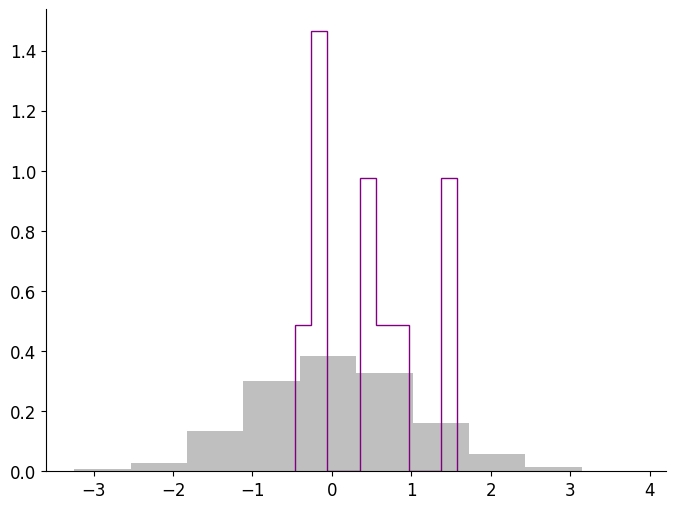

In [54]:
plt.hist(sequence, density=True, alpha=0.5, color="gray")
plt.hist(sequence[:stop_iter], density=True, histtype="step", color="purple")

In [55]:
xx = np.linspace(-2, 2, 1000)
xx_hdi = np.linspace(hdi_min, hdi_max, 1000)

Text(0.5, 0, '$\\hat{\\mu}$')

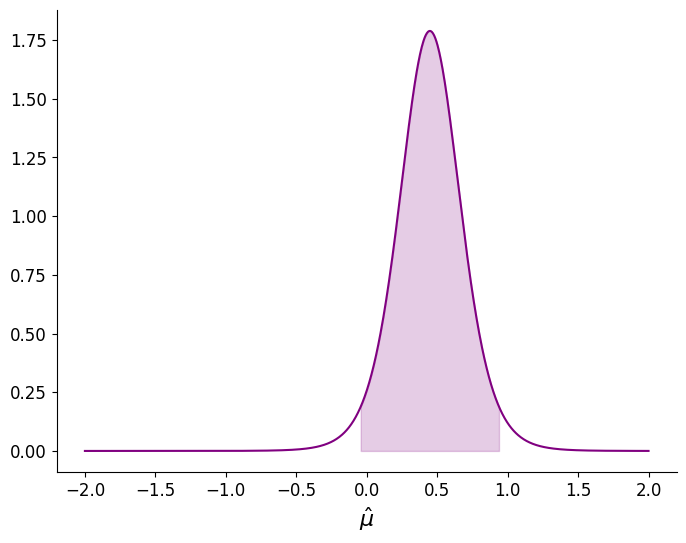

In [56]:
dof = stop_iter - 1  # degrees of freedom
sample_sE = sample_std / np.sqrt(stop_iter)  # standard error of the mean

# pdf = beta.pdf(pp, successes, failures)
pdf = student_t.pdf(xx,  df=dof, loc=sample_mean, scale=sample_sE)
pdf_hdi = student_t.pdf(xx_hdi,  df=dof, loc=sample_mean, scale=sample_sE)

plt.fill_between(xx_hdi, pdf_hdi, color="purple", alpha=0.2) #, label=label_hdi)
plt.plot(xx, pdf, color="purple")
plt.xlabel(r"$\hat{\mu}$")